<a href="https://www.kaggle.com/code/abakashi/titanic-run?scriptVersionId=126821025" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [141]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [142]:
#plot stuff
import matplotlib.pyplot as plt
import seaborn as sns

#balance dataset
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

#PreProcessing, assessment and hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from scipy.stats import kstest

#Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [143]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')

# EDA

> Exploring the variables health.

In [144]:
display(train.info(), train.head(), train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)

- There are missing values in Age, Cabin and Embarked

- Converting some variables to category type.

In [145]:
train = train.astype({
    'PassengerId': 'category',    
    'Pclass': 'category',
    'Sex': 'category',    
    'Embarked': 'category'    
})

In [146]:
train.describe()

,Survived,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


- Checking distributions

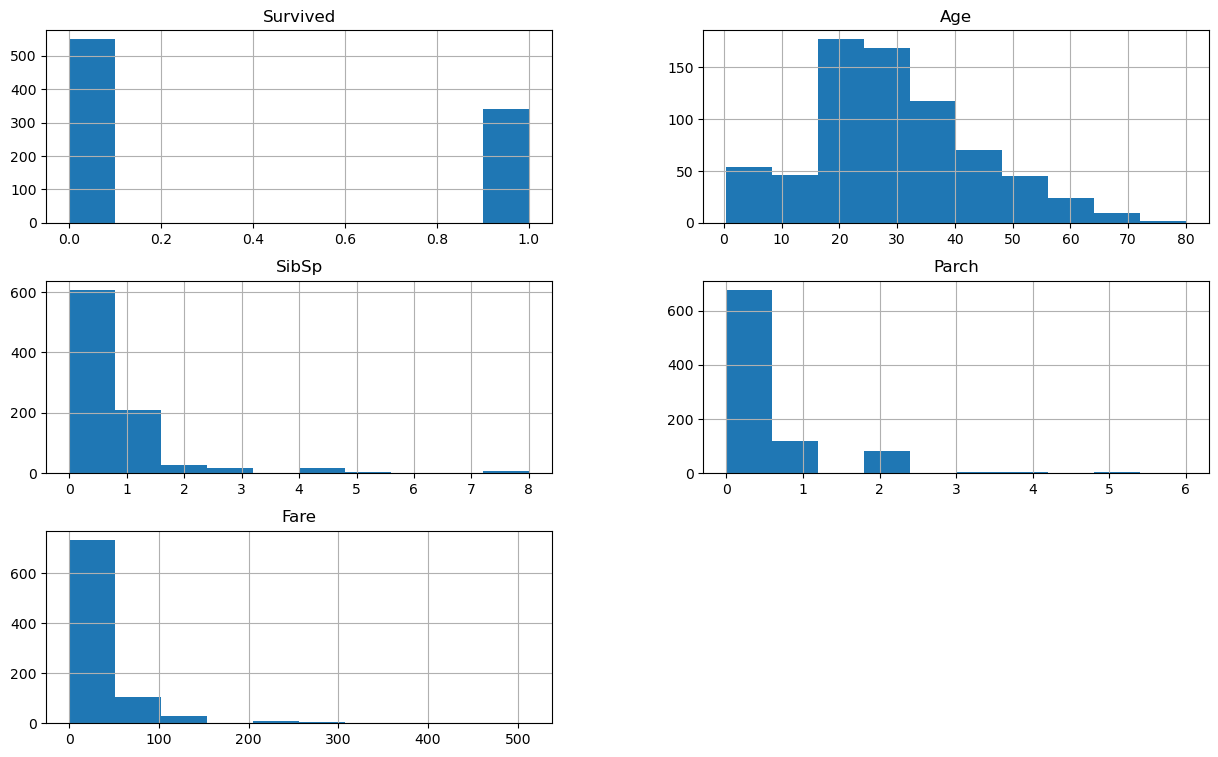

In [147]:
train.hist(figsize=(15,9), bins=10)
plt.show()

> There are potential outliers into the set, just need to check how distant they are from the IQR.

### Plotting some boxplots

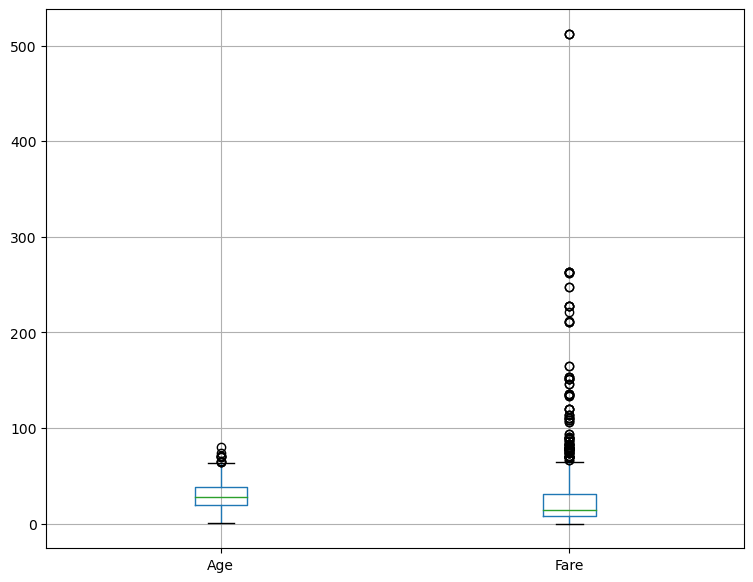

In [148]:
train[['Age', 'Fare']].boxplot(figsize=(9,7))
plt.show()

- Fare seems to be more distant from the IQR; maybe because some variety of passengers would have bought more then one ticket and/or a more expensive one to a better cabin.

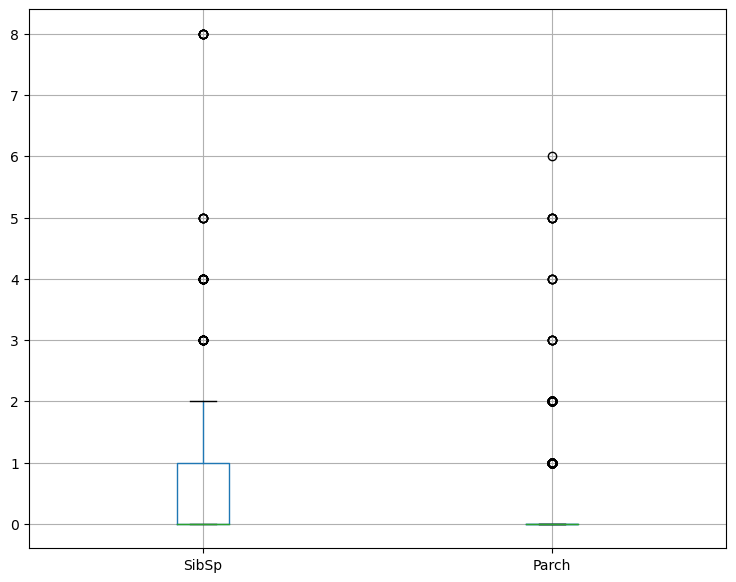

In [149]:
train[['SibSp', 'Parch']].boxplot(figsize=(9,7))
plt.show()

- Most of the passengers boarded the ship alone.

#### Checking the highest outliers

In [150]:
display(
    train[train['Age']<=1].shape,
    train[train['Fare']>100].shape
)

(14, 12)

(53, 12)

In [151]:
train[train['Fare']>100]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,B58 B60,C
195,196,1,1,"Lurette, Miss. Elise",female,58.00,0,0,PC 17569,146.5208,B80,C
215,216,1,1,"Newell, Miss. Madeleine",female,31.00,1,0,35273,113.2750,D36,C
258,259,1,1,"Ward, Miss. Anna",female,35.00,0,0,PC 17755,512.3292,NaN,C
268,269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.00,0,1,PC 17582,153.4625,C125,S
269,270,1,1,"Bissette, Miss. Amelia",female,35.00,0,0,PC 17760,135.6333,C99,S
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S


- Cheking the highest ticket values, we can assume they bout it late or for more than one cabin.

#### Segregating some passengers

In [152]:
#creating a function to segregate people into an age label
def age_lbl(agenum): 
    try:
        agenum = int(np.floor(agenum))
        ages = {
            'baby' : range(0, 3),
            'kid': range(3,13),
            'teenager': range(13, 18),
            'adult': range(18, 60),
            'senior': range(60, 900)
        }
        for key, r in ages.items():
            if agenum in r:
                return key
    except:
        return np.nan
        
#creating a new feature using the function
train['AgeName'] = train['Age'].apply(age_lbl)

#grouping by sex and survival
sexgrp = train.groupby('Sex')\
.agg({
    'Name' : 'count',
    'Survived': 'sum'
})\
.rename(columns={
    'Name': 'Count'
}).reset_index()

#grouping by Pclass and survival
pclassgrp = train.groupby('Pclass')\
.agg({
    'Name' : 'count',
    'Survived': 'sum'
})\
.rename(columns={
    'Name': 'Count'
}).reset_index()

#grouping by Age Label and survival
agrp = train.groupby('AgeName')\
.agg({
    'Name': 'count',
    'Survived': 'sum'
})\
.rename(columns={
    'Name': 'count'
})\
.reset_index()

sexgrp['% surv'] = round((sexgrp['Survived'] / sexgrp['Count'])*100, 2)
pclassgrp['% surv'] = round((pclassgrp['Survived'] / pclassgrp['Count'])*100, 2)
agrp['% surv'] = round((agrp['Survived'] / agrp['count'])*100, 2)


display(sexgrp.sort_values('% surv', ascending=False), 
        pclassgrp.sort_values('% surv', ascending=False), 
        agrp.sort_values('% surv', ascending=False))

,Sex,Count,Survived,% surv
0,female,314,233,74.20
1,male,577,109,18.89


,Pclass,Count,Survived,% surv
0,1,216,136,62.96
1,2,184,87,47.28
2,3,491,119,24.24


,AgeName,count,Survived,% surv
1,baby,24,15,62.50
2,kid,45,25,55.56
4,teenager,44,21,47.73
0,adult,575,222,38.61
3,senior,26,7,26.92


1. Woman survived the most;
2. Pclass 1 Survived the most;
3. Babies survived the most.

> Using the median to fill Age's N/A

In [153]:
age_median = int(train['Age'].median())
train['Age'] = train['Age'].fillna(age_median)

In [154]:
train['AgeName'] = train['Age'].apply(age_lbl)

sexgrp = train.groupby('Sex')\
.agg({
    'Name' : 'count',
    'Survived': 'sum'
})\
.rename(columns={
    'Name': 'Count'
}).reset_index()

pclassgrp = train.groupby('Pclass')\
.agg({
    'Name' : 'count',
    'Survived': 'sum'
})\
.rename(columns={
    'Name': 'Count'
}).reset_index()

agrp = train.groupby('AgeName')\
.agg({
    'Name': 'count',
    'Survived': 'sum'
})\
.rename(columns={
    'Name': 'count'
})\
.reset_index()

sexgrp['% surv'] = round((sexgrp['Survived'] / sexgrp['Count'])*100, 2)
pclassgrp['% surv'] = round((pclassgrp['Survived'] / pclassgrp['Count'])*100, 2)
agrp['% surv'] = round((agrp['Survived'] / agrp['count'])*100, 2)


display(sexgrp.sort_values('% surv', ascending=False), 
        pclassgrp.sort_values('% surv', ascending=False), 
        agrp.sort_values('% surv', ascending=False))

,Sex,Count,Survived,% surv
0,female,314,233,74.20
1,male,577,109,18.89


,Pclass,Count,Survived,% surv
0,1,216,136,62.96
1,2,184,87,47.28
2,3,491,119,24.24


,AgeName,count,Survived,% surv
1,baby,24,15,62.50
2,kid,45,25,55.56
4,teenager,44,21,47.73
0,adult,752,274,36.44
3,senior,26,7,26.92


> Numbers had a little change after filling Age's N/As.

## Embarked

- This feature has only 2 missing values:

In [155]:
train[train['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeName
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,adult
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,senior


> Those 2 people have tickets that starts with 113 and have six digits.

In [156]:
train.groupby('Embarked')\
.agg({
    'PassengerId': 'count',
    'Survived': 'sum'
})

,PassengerId,Survived
Embarked,,
C,168,93
Q,77,30
S,644,217


In [157]:
train[train['Ticket'].str.startswith('113')].groupby('Embarked')\
.agg({
    'PassengerId': 'count'
}).sort_values('PassengerId', ascending=False)

,PassengerId
Embarked,
S,41
C,4
Q,0


> Probably, those two Embarked on Southampton 'S', so we're going to fill these N/As with it.

In [158]:
train['Embarked'] = train['Embarked'].fillna('S')

In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    category
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     891 non-null    category
 12  AgeName      891 non-null    object  
dtypes: category(4), float64(2), int64(3), object(4)
memory usage: 106.8+ KB


In [160]:
(train['Cabin'].notnull().sum()/train.shape[0])*100

22.895622895622896

- There's no point on using the Cabin variable, most of it's values are missing. We're ignoring it.

# Data Transformation

- Checking similarities to the standard distribution

In [161]:
numeric_vars = ['Age', 'SibSp', 'Parch', 'Fare']

for var in numeric_vars:
    stats, pvalue = kstest(train[var], cdf='norm')
    print(f'feature name: {var}\n'
         f'stat_value: {round(stats, 2)}\n',
         f'p_value: {round(pvalue, 5)}', '\n\n')
    


feature name: Age
stat_value: 0.97
 p_value: 0.0 


feature name: SibSp
stat_value: 0.5
 p_value: 0.0 


feature name: Parch
stat_value: 0.5
 p_value: 0.0 


feature name: Fare
stat_value: 0.98
 p_value: 0.0 




KstestResult(statistic=0.1548499940389858, pvalue=4.0096064925900726e-19)

<AxesSubplot:xlabel='Age', ylabel='Density'>

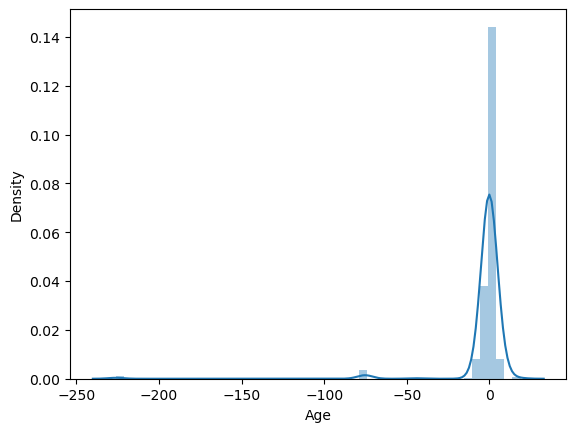

In [162]:
age = np.tan(train[numeric_vars[0]]) #tan
display(kstest(age, cdf='norm'))
sns.distplot(age)

- The KS test seems promising using the tangent transformation

KstestResult(statistic=0.47418630751964086, pvalue=1.771045060128892e-184)

<AxesSubplot:xlabel='SibSp', ylabel='Density'>

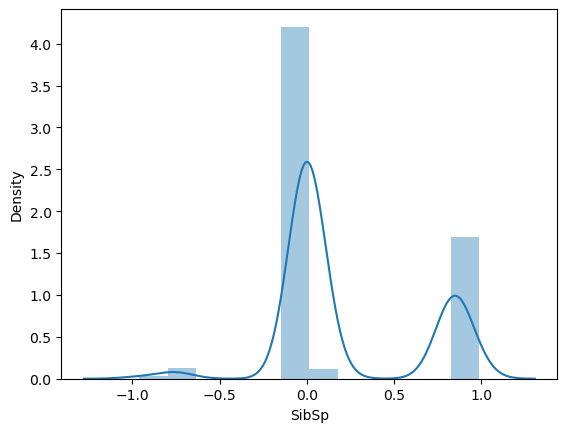

In [163]:
sisbsp = np.sin(train[numeric_vars[1]]) #sin
display(kstest(sisbsp, cdf='norm'))
sns.distplot(sisbsp)

KstestResult(statistic=0.3978675645342312, pvalue=9.652597249447902e-128)

<AxesSubplot:xlabel='Parch', ylabel='Density'>

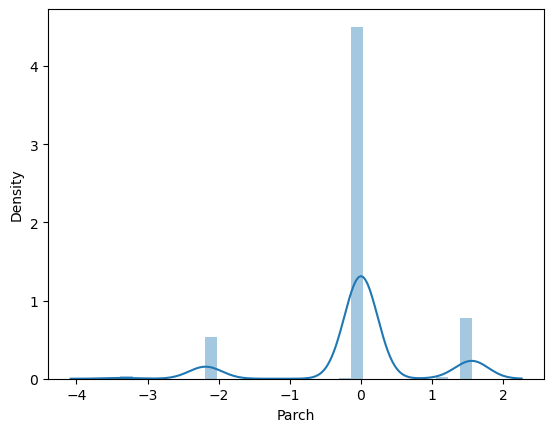

In [164]:
parch = np.tan(train[numeric_vars[2]]) #tan
display(kstest(parch, cdf='norm'))
sns.distplot(parch)

KstestResult(statistic=0.15872430959454165, pvalue=4.482280613823409e-20)

<AxesSubplot:xlabel='Fare', ylabel='Density'>

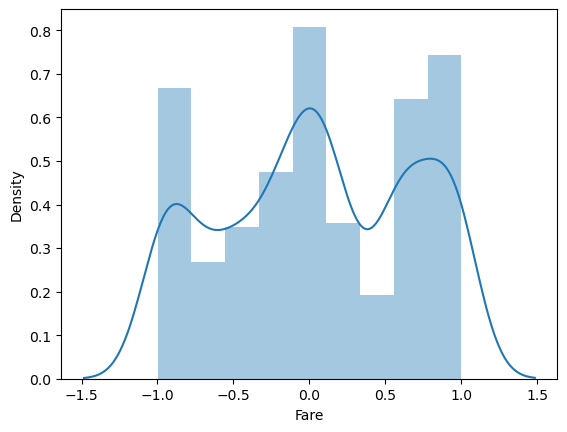

In [165]:
fare = np.cos(train[numeric_vars[3]]) #cos
display(kstest(fare, cdf='norm'))
sns.distplot(fare)

## Transforming features with best KS scored functions

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

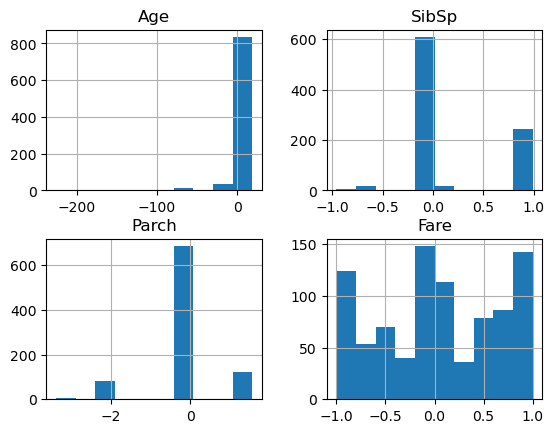

In [166]:
X_transf_nums = pd.DataFrame()
X_transf_nums['Age'] = train['Age'].apply(np.tan)
X_transf_nums['SibSp'] =  train['SibSp'].apply(np.sin)
X_transf_nums['Parch'] = train['Parch'].apply(np.tan)
X_transf_nums['Fare'] = train['Fare'].apply(np.cos)

#---------------------------------------------------------------------------

"""ptrans = PowerTransformer(standardize=False)
X_transf_nums = pd.DataFrame(ptrans.fit_transform(train[numeric_vars]), columns=numeric_vars)"""

X_transf_nums.hist()

# Defining Variables

In [167]:
categoric_vars = ['Pclass', 'Sex', 'Embarked']
target = 'Survived'
r_state = 42
cat_names = range(4,9)

In [168]:
#with or without outliers?
#for var in numeric_vars:
#    train = train[((train[var]>=train[var].quantile(0.25)*1.5)) & ((train[var]<=train[var].quantile(0.75)*1.5))]


In [169]:
train.shape

(891, 13)

# PreProcessing

In [170]:
X = pd.merge(X_transf_nums, train[categoric_vars],left_index= True, right_index=True)
y = train[target]

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=r_state)

X_train =X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

display(X_train.head(), y_train.head(), X_test.head())

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked
0,-0.452316,0.000000,-2.18504,-0.104457,3,male,S
1,-0.452316,-0.756802,-2.18504,0.990086,3,female,S
2,3.743168,0.000000,0.00000,0.617785,1,male,S
3,-0.281430,0.000000,0.00000,0.124458,3,male,Q
4,-0.281430,0.000000,0.00000,-0.041806,3,male,S


0    1
1    0
2    0
3    0
4    0
Name: Survived, dtype: int64

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked
0,-0.281430,0.841471,1.557408,-0.895090,3,male,C
1,-0.441696,0.000000,0.000000,-0.475537,2,male,S
2,2.237161,0.000000,0.000000,-0.070959,3,male,S
3,-0.291006,0.000000,1.557408,-0.013277,2,female,S
4,7.244607,0.841471,0.000000,0.243648,3,female,C


In [172]:
nums = X_train[numeric_vars].copy()
cats = X_train[categoric_vars].copy()



In [173]:
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(cats)
scaler =  StandardScaler() #MinMaxScaler()

"""nums = pd.DataFrame(scaler.fit_transform(nums))
cats = pd.DataFrame(encoder.transform(cats), columns=cat_names)

pp_X_train = pd.merge(nums, cats, left_index=True, right_index=True)"""

#--------------------------------------------------------------------------------------
cats = pd.DataFrame(encoder.transform(cats), columns=cat_names)
pp_X_train = pd.DataFrame(scaler.fit_transform(pd.merge(nums, cats, left_index=True, right_index=True)))

In [174]:
t_nums = X_test[numeric_vars].copy()
t_cats = X_test[categoric_vars].copy()

t_cats = pd.DataFrame(encoder.transform(t_cats), columns=cat_names)
#t_nums = pd.DataFrame(scaler.transform(t_nums))

pp_X_test = pd.DataFrame(scaler.transform(pd.merge(t_nums, t_cats, left_index=True, right_index=True)))


In [175]:
display(
pp_X_test.shape,
pp_X_train.shape
    )

(90, 9)

(801, 9)

In [176]:
display(
pp_X_test.head(),
pp_X_train.head()
    )

,0,1,2,3,4,5,6,7,8
0,0.116154,1.504580,1.735877,-1.495467,-0.517112,0.896691,0.727067,-0.302127,-1.661494
1,0.106965,-0.518729,0.010316,-0.829372,1.933816,-1.115212,0.727067,-0.302127,0.601868
2,0.260573,-0.518729,0.010316,-0.187053,-0.517112,0.896691,0.727067,-0.302127,0.601868
3,0.115605,-0.518729,1.735877,-0.095476,1.933816,-1.115212,-1.375390,-0.302127,0.601868
4,0.547704,1.504580,0.010316,0.312426,-0.517112,0.896691,-1.375390,-0.302127,-1.661494


,0,1,2,3,4,5,6,7,8
0,0.106356,-0.518729,-2.410643,-0.240236,-0.517112,0.896691,0.727067,-0.302127,0.601868
1,0.106356,-2.338453,-2.410643,1.497491,-0.517112,0.896691,-1.375390,-0.302127,0.601868
2,0.346929,-0.518729,0.010316,0.906416,-0.517112,-1.115212,0.727067,-0.302127,0.601868
3,0.116154,-0.518729,0.010316,0.123196,-0.517112,0.896691,0.727067,3.309868,-1.661494
4,0.116154,-0.518729,0.010316,-0.140770,-0.517112,0.896691,0.727067,-0.302127,0.601868


### Balancing Dataset

In [177]:
#balance = RandomOverSampler(random_state=r_state, sampling_strategy='auto')
#balance = ADASYN(random_state=r_state, sampling_strategy='auto')
"""balance = SMOTE(random_state=r_state, sampling_strategy='auto')
pp_X_train, y_train = balance.fit_resample(pp_X_train, y_train)

pd.merge(pp_X_train, y_train, left_index=True, right_index=True)\
.groupby('Survived')\
.agg({0 : 'count'})"""

"balance = SMOTE(random_state=r_state, sampling_strategy='auto')\npp_X_train, y_train = balance.fit_resample(pp_X_train, y_train)\n\npd.merge(pp_X_train, y_train, left_index=True, right_index=True).groupby('Survived').agg({0 : 'count'})"

# Model Assessment

- Model selection and hyperparameter settings for GridSearch

In [178]:
models = {
    'xgb.XGBClassifier': xgb.XGBClassifier(),
    'LogisticRegression' : LogisticRegression(),
    'KNeighborsClassifier' : KNeighborsClassifier(),
    #'SVC' : SVC(),
    'GaussianProcessClassifier' : GaussianProcessClassifier(),
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'RandomForestClassifier' : RandomForestClassifier(),
    'AdaBoostClassifier' : AdaBoostClassifier()
}

params_grid = {
    'LogisticRegression' : {
        'fit_intercept': [True, False]
    },
    'KNeighborsClassifier' : {
        'n_neighbors': range(3,9,2),
        'algorithm': ['brute', 'kd_tree', 'ball_tree'],
        'leaf_size': range(10,40,5),
        'p': [1,2]
    },
    'SVC' : {
        'C': [1,2],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': range(1,4),
        'coef0': list(np.arange(0,2.1, 0.1))
    },
    'GaussianProcessClassifier' : {        
        'max_iter_predict': range(50, 250, 50)
    },
    'DecisionTreeClassifier' : {
        'criterion': ['gini', 'entropy'],
        'min_samples_split': range(2,9),
        'min_samples_leaf': range(1,5)
    },
    'RandomForestClassifier' : {
        'n_estimators': range(50,350,50),
        'criterion': ['gini', 'entropy'],
        'min_samples_split': range(2,9),
        'min_samples_leaf': range(1,5),
        'max_features' : ['sqrt ', 'log2']
    },
    'AdaBoostClassifier' : {
        'n_estimators': range(30,325,25),
        'algorithm': ['SAMME', 'SAMME.R']        
    },
    'GaussianNB' : {},
    'MLPClassifier': {
        'hidden_layer_sizes': [(50,50), (50, 100), (50,50,50), (50, 50, 50, 50), (100,100,100)],
        'max_iter': range(900, 3500, 500)
    },
    'xgb.XGBClassifier': {
        "learning_rate": list(np.arange(0.09,1.01,0.01)),
        "max_depth": range(5,10),
        "min_child_weight": [1],
        "gamma": np.arange(0.1, 1.0, 0.1),
        "colsample_bytree": [1]
    }
}


- Running the tests with the algorithms and hyperparameter tunning

In [179]:
scores = []
sc_names = ['model', 'accuracy', 'f1', 'recall', 'precision', 'best_params']

for name, model in models.items():
    gsearch = GridSearchCV(model, params_grid[name], scoring='f1', cv=3, verbose=1, n_jobs=-1)
    gsearch.fit(pp_X_train, y_train)
    pred = gsearch.best_estimator_.predict(pp_X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    recall = recall_score(y_test, pred)
    prec = precision_score(y_test, pred)
    
    scores.append([
        name,
        round(acc, 4),
        round(f1, 4),
        round(recall, 4),
        round(prec, 4),
        gsearch.best_params_
        ])
scores = pd.DataFrame(scores, columns=sc_names)

Fitting 3 folds for each of 4140 candidates, totalling 12420 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 56 candidates, totalling 168 fits
Fitting 3 folds for each of 672 candidates, totalling 2016 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


## Best classifier

In [180]:
srt_score = scores.sort_values(['f1', 'accuracy'], ascending=False).reset_index(drop=True)

srt_score

,model,accuracy,f1,recall,precision,best_params
0,xgb.XGBClassifier,0.8444,0.8056,0.8056,0.8056,"{'colsample_bytree': 1, 'gamma': 0.8, 'learnin..."
1,RandomForestClassifier,0.8444,0.8000,0.7778,0.8235,"{'criterion': 'gini', 'max_features': 'log2', ..."
2,AdaBoostClassifier,0.8222,0.7838,0.8056,0.7632,"{'algorithm': 'SAMME.R', 'n_estimators': 155}"
3,DecisionTreeClassifier,0.7889,0.7654,0.8611,0.6889,"{'criterion': 'entropy', 'min_samples_leaf': 4..."
4,GaussianProcessClassifier,0.7889,0.7467,0.7778,0.7179,{'max_iter_predict': 50}
5,LogisticRegression,0.7778,0.7436,0.8056,0.6905,{'fit_intercept': True}
6,KNeighborsClassifier,0.7778,0.7368,0.7778,0.7000,"{'algorithm': 'brute', 'leaf_size': 10, 'n_nei..."


In [181]:
display(srt_score.loc[0]['model'],
srt_score.loc[0]['best_params'])

'xgb.XGBClassifier'

{'colsample_bytree': 1,
 'gamma': 0.8,
 'learning_rate': 0.9699999999999995,
 'max_depth': 5,
 'min_child_weight': 1}

# Creating the instance of the best estimator

In [182]:
clf = eval(srt_score.loc[0]['model'])(**srt_score.loc[0]['best_params'])

clf.fit(pp_X_train, y_train)
pred = clf.predict(pp_X_test)

In [183]:
display(confusion_matrix(y_test, pred), 
       print(classification_report(y_test, pred)))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        54
           1       0.81      0.81      0.81        36

    accuracy                           0.84        90
   macro avg       0.84      0.84      0.84        90
weighted avg       0.84      0.84      0.84        90



array([[47,  7],
       [ 7, 29]])

None

# Predicting test dataset.

In [184]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
gender_sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

display(
    test.head(10),
    gender_sub.head(10), 
    test.shape,
    gender_sub.shape
)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


(418, 11)

(418, 2)

- There are some missing values

In [185]:
X_test2 = test[[*numeric_vars, *categoric_vars]].copy()
X_test2 = pd.merge(X_test2, gender_sub['Survived'], left_index=True, right_index=True)


X_test2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       332 non-null    float64
 1   SibSp     418 non-null    int64  
 2   Parch     418 non-null    int64  
 3   Fare      417 non-null    float64
 4   Pclass    418 non-null    int64  
 5   Sex       418 non-null    object 
 6   Embarked  418 non-null    object 
 7   Survived  418 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


- Creating a data label feature to separate passengers and their ages and fares

In [186]:
X_test2['Age_Label'] = X_test2['Age'].apply(age_lbl)

- 86 missing age values

In [187]:
X_test2[X_test2['Age'].isna()]

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked,Survived,Age_Label
10,NaN,0,0,7.8958,3,male,S,0,NaN
22,NaN,0,0,31.6833,1,female,S,1,NaN
29,NaN,2,0,21.6792,3,male,C,0,NaN
33,NaN,1,2,23.4500,3,female,S,1,NaN
36,NaN,0,0,8.0500,3,female,S,1,NaN
...,...,...,...,...,...,...,...,...,...
408,NaN,0,0,7.7208,3,female,Q,1,NaN
410,NaN,0,0,7.7500,3,female,Q,1,NaN
413,NaN,0,0,8.0500,3,male,S,0,NaN
416,NaN,0,0,8.0500,3,male,S,0,NaN


- One fare missing value

In [188]:
X_test2[X_test2['Fare'].isna()]

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked,Survived,Age_Label
152,60.5,0,0,NaN,3,male,S,0,senior


- Creating aggragation reference

In [189]:
grp_age_xt2 = X_test2.groupby('Age_Label')\
.agg({
    'Age': 'mean',
    'Fare': 'median'
})

display(grp_age_xt2.sort_values('Fare'))

,Age,Fare
Age_Label,,
adult,31.714801,14.50000
teenager,15.468750,18.17500
baby,1.000000,18.45625
kid,8.166667,21.07500
senior,63.250000,76.29170


- Replacing missing values with the mean/median values

In [190]:
X_test2.at[X_test2[(X_test2['Age'].isna()) & X_test2['Fare']<18.1].index, 'Age'] = 31.71
X_test2.at[X_test2[(X_test2['Age'].isna()) & ((X_test2['Fare']>=18.5) & (X_test2['Fare']<21.1))].index, 'Age'] = 8.16
X_test2.at[X_test2[(X_test2['Age'].isna()) & (X_test2['Fare']>=21.1)].index, 'Age'] = 63.25

In [191]:
X_test2.at[X_test2[X_test2['Fare'].isna()].index, 'Fare'] = 76

In [192]:
X_test2['Age'] = X_test2['Age'].apply(np.tan)
X_test2['SibSp'] =  X_test2['SibSp'].apply(np.sin)
X_test2['Parch'] = X_test2['Parch'].apply(np.tan)
X_test2['Fare'] = X_test2['Fare'].apply(np.cos)

"""X_test2[numeric_vars] = pd.DataFrame(ptrans.transform(X_test2[numeric_vars]), columns=numeric_vars)"""

'X_test2[numeric_vars] = pd.DataFrame(ptrans.transform(X_test2[numeric_vars]), columns=numeric_vars)'

> Checking missing values again

In [193]:
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        418 non-null    float64
 1   SibSp      418 non-null    float64
 2   Parch      418 non-null    float64
 3   Fare       418 non-null    float64
 4   Pclass     418 non-null    int64  
 5   Sex        418 non-null    object 
 6   Embarked   418 non-null    object 
 7   Survived   418 non-null    int64  
 8   Age_Label  332 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 29.5+ KB


- Preprocessing and checking the features, separating target.

In [194]:
y_test2 = X_test2['Survived']
X_test2 = X_test2[[*numeric_vars, *categoric_vars]]

Xt2_nums = X_test2[numeric_vars]
Xt2_cats = pd.DataFrame(encoder.transform(X_test2[categoric_vars]), columns=cat_names)

pp_X_test2 = pd.DataFrame(scaler.transform(pd.merge(Xt2_nums, Xt2_cats, left_index=True, right_index=True)))

display(pp_X_test2.head())

,0,1,2,3,4,5,6,7,8
0,0.149658,-0.518729,0.010316,-0.035057,-0.517112,0.896691,0.727067,3.309868,-1.661494
1,0.149658,1.504580,0.010316,1.122519,-0.517112,0.896691,-1.375390,-0.302127,0.601868
2,0.149658,-0.518729,0.010316,-1.607548,1.933816,-1.115212,0.727067,3.309868,-1.661494
3,0.149658,-0.518729,0.010316,-1.222672,-0.517112,0.896691,0.727067,-0.302127,0.601868
4,0.149658,1.504580,1.735877,1.451896,-0.517112,0.896691,-1.375390,-0.302127,0.601868


In [195]:
display(
    pp_X_test2.shape,
    y_test2.shape
)

(418, 9)

(418,)

- Predicting

In [196]:
pred2 = clf.predict(pp_X_test2)

In [197]:
display(confusion_matrix(y_test2, pred2))

array([[237,  29],
       [ 25, 127]])

- Checking classification report

In [198]:
print(classification_report(y_test2, pred2))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       266
           1       0.81      0.84      0.82       152

    accuracy                           0.87       418
   macro avg       0.86      0.86      0.86       418
weighted avg       0.87      0.87      0.87       418



- Joining the results with the PassengerID

In [199]:
gender_sub = pd.DataFrame()
gender_sub['PassengerId'] = test['PassengerId']
gender_sub['Survived'] = pd.Series(pred2)

gender_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


- Saving predictions into a .csv file.

In [200]:
gender_sub.to_csv('/kaggle/working/submission.csv',index=False)